In [1]:
import openml
import pandas as pd
import numpy as np

dataset = openml.datasets.get_dataset(40996)
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

df = pd.DataFrame(X)
df['label'] = y

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Unique classes: {np.unique(y)}")

print(df.describe())


C:\Users\TARGARYEN\AppData\Local\Temp\ipykernel_15152\3909831616.py:6: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = openml.datasets.get_dataset(40996)


Shape of X: (70000, 784)
Shape of y: (70000,)
Unique classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
             pixel1        pixel2        pixel3        pixel4        pixel5  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean       0.000771      0.006414      0.034486      0.098886      0.247843   
std        0.087339      0.296605      1.200882      2.458872      4.408110   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max       16.000000     45.000000    218.000000    185.000000    227.000000   

             pixel6        pixel7        pixel8        pixel9      pixel10  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.00000   
mean       0.408714      0.8

In [2]:
from sklearn.decomposition import PCA

X_flat = X.to_numpy().reshape(X.shape[0], -1)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")


Explained variance ratio: [0.2905654  0.17738509]


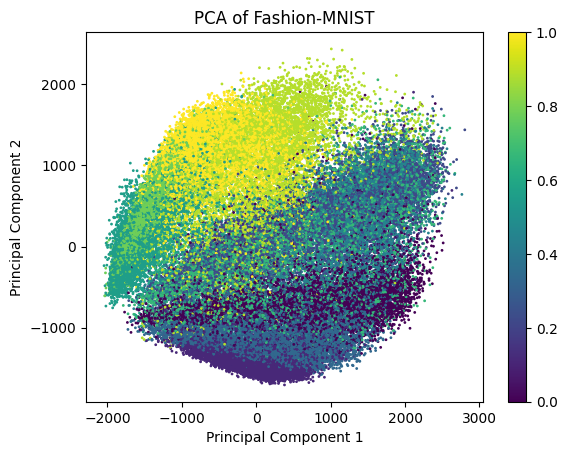

In [3]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

colors = plt.cm.viridis(np.linspace(0, 1, len(np.unique(y))))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=[colors[i] for i in y_encoded], s=1)
plt.colorbar()
plt.title('PCA of Fashion-MNIST')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
model = Model(inputs=vgg16.input, outputs=vgg16.get_layer('block5_pool').output)

X_resized = np.array([np.resize(img, (32, 32, 3)) for img in X.to_numpy().reshape(-1, 28, 28)])
X_preprocessed = preprocess_input(X_resized)

X_features = model.predict(X_preprocessed)
X_flat_features = X_features.reshape(X_features.shape[0], -1)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 382s 174ms/step


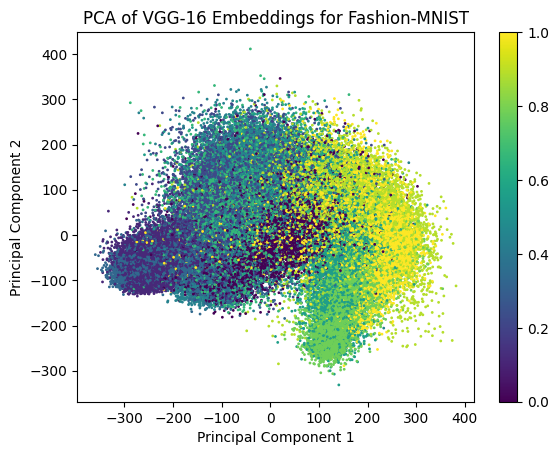

In [5]:
pca_vgg = PCA(n_components=2)
X_pca_vgg = pca_vgg.fit_transform(X_flat_features)

plt.scatter(X_pca_vgg[:, 0], X_pca_vgg[:, 1], c=[colors[i] for i in y_encoded], s=1)
plt.colorbar()
plt.title('PCA of VGG-16 Embeddings for Fashion-MNIST')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

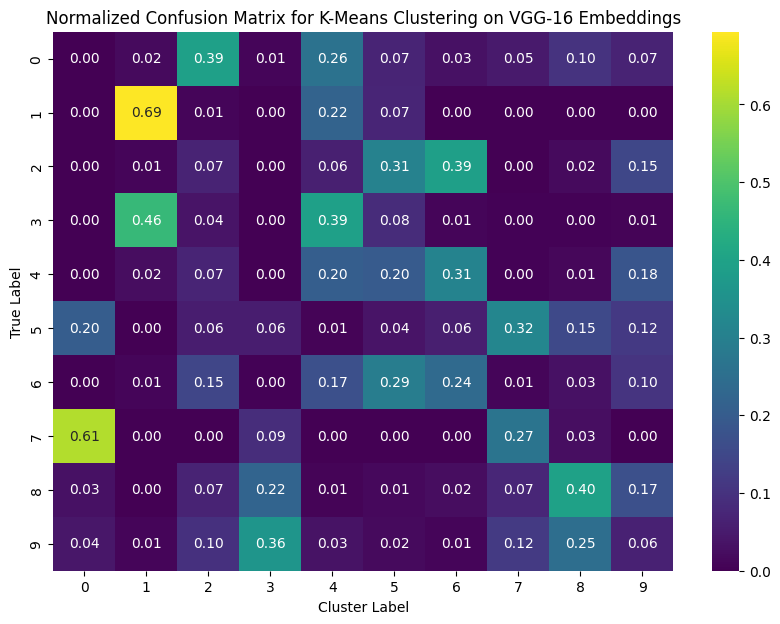

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns

kmeans_vgg = KMeans(n_clusters=10, random_state=42)
clusters_vgg = kmeans_vgg.fit_predict(X_pca_vgg)

conf_matrix_vgg = confusion_matrix(y_encoded, clusters_vgg)

conf_matrix_normalized_vgg = conf_matrix_vgg.astype('float') / conf_matrix_vgg.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_normalized_vgg, annot=True, fmt='.2f', cmap='viridis')
plt.title('Normalized Confusion Matrix for K-Means Clustering on VGG-16 Embeddings')
plt.xlabel('Cluster Label')
plt.ylabel('True Label')
plt.show()


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train_vgg, X_test_vgg, y_train_vgg, y_test_vgg = train_test_split(X_flat_features, y_encoded, test_size=0.2, random_state=42)

clf_vgg = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_vgg.fit(X_train_vgg, y_train_vgg)

y_pred_vgg = clf_vgg.predict(X_test_vgg)

print(classification_report(y_test_vgg, y_pred_vgg))


              precision    recall  f1-score   support

           0       0.69      0.72      0.71      1394
           1       0.95      0.90      0.93      1402
           2       0.67      0.71      0.69      1407
           3       0.74      0.81      0.77      1449
           4       0.68      0.67      0.68      1357
           5       0.82      0.82      0.82      1449
           6       0.59      0.45      0.51      1407
           7       0.83      0.86      0.84      1359
           8       0.86      0.91      0.89      1342
           9       0.87      0.88      0.87      1434

    accuracy                           0.77     14000
   macro avg       0.77      0.77      0.77     14000
weighted avg       0.77      0.77      0.77     14000

